In [1]:
import gym
gym.logger.set_level(40)

import random
import numpy as np
from collections import deque

import torch

from IPython import display
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from ddpg import DDPGAgent
from model import Actor, Critic

In [2]:
env = gym.make('LunarLanderContinuous-v2')
o_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
print('State shape: ', o_dim)
print('Action shape: ', a_dim)

# each action dim value ranges from -1 to 1, so add tanh as to the actor network
print(env.action_space.high,env.action_space.low)
# action scale and state scale are different, so apply a separate layer before concat
print(env.observation_space.high,env.observation_space.low)

State shape:  8
Action shape:  2
[1. 1.] [-1. -1.]
[inf inf inf inf inf inf inf inf] [-inf -inf -inf -inf -inf -inf -inf -inf]


In [3]:
# agent parameters
LR_ACTOR = 5e-4         # actor learning rate
LR_CRITIC = 5e-4        # critic learning rate
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
BUFFER_SIZE = int(1e6)  # replay buffer size     
SEED = 1234

agent = DDPGAgent(Actor, Critic, o_dim, a_dim, 64, initialize_weights = True,
                  lr_actor = LR_ACTOR, lr_critic = LR_CRITIC,
                  batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, buffer_size = BUFFER_SIZE,
                  seed = SEED)

print(agent.actor)
print(agent.critic)
print(agent.loss_fn)
print(agent.initialize_weights)

Actor(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
    (3): Tanh()
  )
)
Critic(
  (obs_fc): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): Linear(in_features=66, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
SmoothL1Loss()
True


In [4]:
# parameters for training
NUM_EPISODES = 800
PRINT_EVERY = 50
TMAX = 1000

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.99

In [5]:
score_list = []
score_window = deque(maxlen = PRINT_EVERY)  
best_score = 0.0

eps = eps_start

In [6]:
for e in range(1, NUM_EPISODES+1):
    
    state = env.reset() # reset environment
    agent.reset() # reset noise process
    score = 0
    for t in range(TMAX):
        action = agent.get_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        
        if mean_score >= best_score:
            print('\nmodel saved!')
            torch.save(agent.actor.state_dict(), 'checkpoint.pth')
            best_score = mean_score



Episode 50	sum of rewards  -210.62
Episode 100	sum of rewards  -217.94
Episode 150	sum of rewards  -116.81
Episode 200	sum of rewards    34.00

model saved!
Episode 250	sum of rewards    95.86

model saved!
Episode 300	sum of rewards    92.06
Episode 350	sum of rewards    34.62
Episode 400	sum of rewards    38.58
Episode 450	sum of rewards   126.49

model saved!
Episode 500	sum of rewards    37.92
Episode 550	sum of rewards    53.20
Episode 600	sum of rewards   163.92

model saved!
Episode 650	sum of rewards   132.23
Episode 700	sum of rewards   213.17

model saved!
Episode 750	sum of rewards   201.76
Episode 800	sum of rewards   141.32


In [8]:
# load checkpoint
agent.actor.load_state_dict(torch.load('checkpoint.pth'))
# load to cpu and save the best weights
torch.save(agent.actor.cpu().state_dict(), "ddpg_LunarLander.pth")

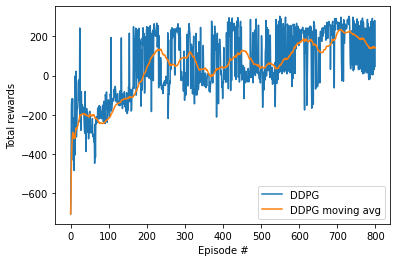

In [9]:
score1 = np.asarray(score_list).T

fig = plt.figure()
plt.plot(np.arange(score1.shape[1]), score1[0], label = "DDPG")
plt.plot(np.arange(score1.shape[1]), score1[1], label = "DDPG moving avg")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [10]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, '../video', force=True)
    return env

env = wrap_env( gym.make('LunarLanderContinuous-v2'))

state = env.reset()
while True:
    action = agent.get_action(state, False)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break


env.close()